In [1]:
import pandas
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Introduction

On September 28, 1984, the hit single "Let's Go Crazy" by Prince and The Revolution climbed to the top of the U.S. Billboard charts ("Chart History: Prince"), becoming the first song to ever top Billboard despite being marked as "explicit" (Ross). Since then, songs featuring explicit content have become increasingly popular, with recent studies of Billboard chart data revealing that the proportion of Billboard number-one singles with explicit content has surged from below 10% in 1984 to over 60% in 2017 (Bannister.) This in turn raises the question: **given the recent rise in commercial success of explicit music, has critical reception of explicit music similarly improved over the years?**

To answer this question, I began by scraping data from Metacritic (https://www.metacritic.com/music, a website that aggregates various critic reviews of music, among other forms of entertainment) and Genius (https://genius.com/, a website centered around song lyrics and music news). Specifically, I focused on exploring every album in the Metacritic database that was released in the 2015-2019 range. Using lyrical data from Genius, I computed the specific percentage and quantity of explicit content on each of these albums, and found that in general...

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

# Data Description

As aforementioned, the dataset utilized in this study (which can be found [here](https://github.com/genghisshyy/INFO_2950_FinalProject/blob/master/data/condensed_albums.csv)) was manually constructed by scraping web data from Metacritic and Genius. We explore this dataset in further detail below:

### What are the observations and the attributes of this dataset?

Each observation in this dataset represents an album, with the entire set of observations representing all albums in the Metacritic database that were released in the 2015-2019 range.\* For each of these 3,226 albums, eight attributes are stored in the dataset:

1. `artist`, the name of the album artist; 
2. `metascore`, the average critic score (on an integer scale from 0-100) that the album received on Metacritic; 
3. `num_lyric_tracks`, the number of album tracks that have lyrics available on Genius;
4. `release_date`, the date on which the album was released;
5. `title`, the title of the album; 
6. `user_score`, the average user score (on a decimal scale from 0.0-10.0) that the album received from Metacritic users;
7. `explicit_count`, the total number of "explicit"\*\*\* words the entire album contains (based off the lyrics available on Genius); and
8. `explicit_avg`, the average number of "explicit" words per track (again, only when considering tracks that have lyrics available on Genius).

\**Note:* All album data used in this study was accurate as of May 20, 2020.

\*\**Note:* Below is the complete list of words considered "explicit" in this study. This is not a comprehensive list of "explicit" words, but rather a manually written compilation of words that are commonly regarded as "explicit" in the music industry.

In [2]:
# The inclusion of these words here is strictly for research purposes.
explicit_list = [
    "arse",
    "ass",
    "asshole",
    "assholes",
    "bastard",
    "bastards",
    "bitch",
    "bitches",
    "bullshit",
    "cocaine",
    "cock",
    "coke",
    "damn",
    "dick",
    "drug",
    "drugs",
    "faggot",
    "faggots",
    "fentanyl",
    "fuck",
    "fucka",
    "fucked",
    "fucker",
    "fuckin",
    "fucking",
    "fucks",
    "goddamn",
    "hell",
    "horseshit",
    "mothafucka",
    "mothafuckas",
    "motherfucka",
    "motherfuckas",
    "motherfucker",
    "motherfuckers"
    "motherfuckin",
    "motherfucking",
    "nigga",
    "niggas",
    "nigger",
    "niggers",
    "perc",
    "percocet",
    "pill",
    "pills",
    "pussy",
    "sex",
    "shit",
    "slut",
    "sluts",
    "whore",
    "whores"
]

### Why was this dataset created?

This dataset was created solely for the purpose of carrying out this study, and therefore is meant to facilitate analysis of any potential relationships between the amount of explicit content in an album and the album’s critical reception.

### Who funded the creation of this dataset?

There were no significant funds necessary to create this dataset, and indeed no grant associated with this dataset either.

### What processes might have influenced what data was observed and recorded and what was not?

For one, Metacritic itself already prevents certain releases from being included in their year-end album rankings, noting, “Only albums with seven or more reviews are eligible. EPs, live albums, box sets, re-issues, and compilations are also excluded” ("Best Music and Albums for 2020"). Therefore, all projects deemed “ineligible” by Metacritic are not included in this study's dataset either.

In addition, album lyrics data might not be collected completely for each album, given that Genius does not include a lyrics page for every track of every album in the dataset. (For example, Genius does not provide lyrics for the last six tracks of *Grassed In* by Australian rock band Blank Realm.)

### What preprocessing was done, and how did the data come to be in the form that you are using?

Since this dataset was constructed manually for the purpose of carrying out this study, there was no point where an already-compiled dataset had to be pre-processed. However, the process of building this dataset was fairly similar to the usual stage of pre-processing, and therefore is explained below:

##### Scraping Basic Album Information from Metacritic

First, data for every album in the Metacritic database (that was released in the 2015-2019 range) was collected by copying and pasting directly from Metacritic web pages to a Microsoft Excel spreadsheet. (An example of one such web page can be found [here](https://www.metacritic.com/browse/albums/score/metascore/year/filtered?view=condensed&sort=desc).) Overall, data for 3,226 albums was collected, and subsequently arranged in five different columns (one for each year.) In each of these columns, every set of five rows (beginning with the set of rows 0, 1, 2, 3, and 4) represented a single album, with the rows corresponded to the following album data:

- Row 0: the name of the album artist
- Row 1: the metascore, or the average critic score (on a scale from 0-100) that the album received on Metacritic
- Row 2: the title of the album
- Row 3: the average user score (on a scale from 0.0-10.0) that the album received from Metacritic users
- Row 4: the date on which the album was released

With this row structure in mind, the spreadsheet was converted to a CSV file (comma-separated values file), which can be found [here](https://github.com/genghisshyy/INFO_2950_FinalProject/blob/master/data/metacritic_data.csv). This file was then converted to a Pandas DataFrame object for further data processing. From there, by iterating through the values of each column in the DataFrame object (which corresponded to the columns of the spreadsheet), a dictionary representing each album could be constructed for each set of five rows, in each of the five columns. An example of one such dictionary is given below:

`{'artist': 'Car Seat Headrest',
'metascore': '76',
'release_date': '1-May-20',
'title': 'Making a Door Less Open',
'user_score': '7.1'}`

This process therefore culminated in five lists of dictionaries, one for each year from 2015 to 2019.

##### Scraping Album Lyrics from Genius (Part 1)

To obtain album lyrics data, a Genius URL was dynamically constructed for each album in the dataset, using the artist name and album title (ex: http://genius.com/albums/The-weeknd/After-hours, where "The Weeknd" is the artist name and *After Hours* is the album title.) Each of these Genius URLs contains an overview on the album in question, including a tracklist and links to pages for all available track lyrics. Lyrics were then scraped from each of these lyrics pages using the Python libraries `requests` and `BeautifulSoup`, and subsequently stored in the appropriate dictionary to lead to each dictionary featuring the following format:

`{"artist": (name of album artist),
"metascore": (average critic score that album received on Metacritic, on integer scale 0-100),
"release_date": (day on which album was released in the format d-mmm-yy, e.g. 6-Mar-20),
"title": (title of album),
"user_score": (average user score that album received on Metacritic, on decimal scale 0.0-10.0),
"lyrics": (a list of strings, where each string is a concatenation of all lyrics from a single track on the album),
"num_lyric_tracks": (the number of album tracks that had lyrics available on Genius)}`

##### Scraping Lyrics from Genius (Part 2)

At this point, however, preliminary analysis of this dataset revealed that approximately a quarter of all album entries did not have any scraped lyrics. Granted, some of these albums were found to be purely instrumental records, while other albums simply were not included in the Genius lyrics database. However, it did seem apparent that the appearance of punctuation in the title of an album or the name of its artist was causing invalid Genius URL's to be generated during the initial lyrics scraping process discussed above. Therefore, additional lyrics scraping had to be performed.

More specifically, two new algorithms for lyrics scraping were developed. The first of these (which will be referred to as the "normal alternative" algorithm) replaces all ampersands with the word "and." (For example, if the album *Look Now* by Elvis Costello & The Imposters were to be examined, running this algorithm would lead to "https://genius.com/albums/Elvis-costello-and-the-imposters/Look-now" being generated as opposed to "http://genius.com/albums/Elvis-costello---the-imposters/Look-now" like before.) Additionally, this algorithm removes all other punctuation marks as opposed to replacing punctuation marks with spaces. (This was designed to handle specific edge cases such as the one illustrated by *DAMN.* by Kendrick Lamar. Using the initial algorithm, the period at the end of *DAMN.* would be replaced by a space, which in turn led to http://genius.com/albums/Kendrick-lamar/Damn- being generated instead of http://genius.com/albums/Kendrick-lamar/Damn as desired.)

In addition to this updated algorithm, a second algorithm was created, which simply used manually scraped URL's to access lyrics data. In other words, for each album that still did not have any stored lyrics after the initial and the "normal alternative" algorithms were executed, the correct URL (if one existed) was manually recovered through web searches, and subsequently used to scrape all available lyrics data.

##### Gathering Data on Explicit Content for Each Album

Having completed the lyrics scraping phase, data on the amount of explicit content in each album could be collected. Using the list of explicit words given above in the "What are the attributes and the attributes of this dataset?" section, the number of explicit words that appeared in every album's lyrics was recorded, in addition to the average number of "explicit" words that appear per album track. Both of these attributes were then appropriately stored in the dataset for each of the 1,500 albums.

##### Exporting Data to CSV File

Finally, a single list was created, containing all dataset observations. This list was then converted into a Pandas DataFrame object, which was subsequently exported to a CSV (comma-separated values) file for convenient storage and access. For a more programmatic overview of this data collection process, please see the source code [here](https://github.com/genghisshyy/INFO_2950_FinalProject/blob/master/dataset_creation.py).

### If people are involved, were they aware of this data collection and if so, what purpose did they expect the data to be used for?

No people were involved in the process of collecting data (in terms of getting surveyed for personal information), as all data was simply scraped off of web pages already available online.

### Where can your raw source data be found, if applicable?

The raw, unprocessed data scraped directly from Metacritic is available [here](https://github.com/genghisshyy/INFO_2950_FinalProject/blob/master/data/metacritic_data.csv).

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

# Data Analysis

We begin by loading the dataset below:

In [2]:
albums = pandas.read_csv("../data/condensed_albums.csv")
albums.head()

,artist,metascore,num_lyric_tracks,release_date,title,user_score,explicit_count,explicit_avg
0,Justin Bieber,57,17,14-Feb-20,Changes,5.7,4,0.235294
1,Beach Slang,59,11,10-Jan-20,The Deadbeat Bang of Heartbreak City,4.5,27,2.454545
2,James Taylor,60,16,28-Feb-20,American Standard,8.5,0,0.000000
3,DaBaby,61,13,17-Apr-20,Blame It on Baby,4.5,330,25.384615
4,Morrissey,62,11,20-Mar-20,I Am Not a Dog on a Chain,8.3,1,0.090909


Since this study revolves around analyzing any potential relationships between the amount of explicit content on an album and that album's critical reception, it is reasonable to first explore the data available on each album's explicit content:

##### Exploring Data on Explicit Album Content

In [4]:
# computing relevant means and standard deviations
print("There is an average of", albums["explicit_count"].mean(), \
      "explicit words on each album in the dataset, with a standard deviation of approximately", \
      round(albums["explicit_count"].std(), 2), "explicit words.")
print("Additionally, there is an average of approximately", round(albums["explicit_avg"].mean(), 3), \
      "explicit words per track for each album in the dataset, with a standard deviation of approximately", \
      round(albums["explicit_avg"].std(), 2), "explicit words per track.")

There is an average of 19.324 explicit words on each album in the dataset, with a standard deviation of approximately 56.21 explicit words.
Additionally, there is an average of approximately 1.288 explicit words per track for each album in the dataset, with a standard deviation of approximately 3.44 explicit words per track.


We can also check the frequency distribution of explicit word count below:

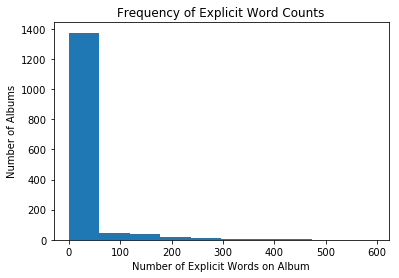

In [5]:
# creating histogram using full dataset (alternate histogram further down below)
plt.hist(albums["explicit_count"])
plt.title("Frequency of Explicit Word Counts")
plt.xlabel("Number of Explicit Words on Album")
plt.ylabel("Number of Albums")
plt.show()

Clearly, the distribution of explicit word counts is heavily skewed left, which seems to indicate that most albums in the dataset feature little to no explicit content. The average of 19.324 explicit words per album therefore seems at least partially inflated by a small number of albums featuring heavy explicit content. Specifically, we can observe the following:

In [6]:
# number of albums with no explicit words
num_clean_albums = len(albums[albums["explicit_count"] == 0])

print("There are", num_clean_albums, "albums that contain no explicit words at all.")
print("This represents approximately " + str(round(num_clean_albums/len(albums)*100, 2)) \
      + "% of the albums in the dataset.\n")

# number of albums with over 200 explicit words
num_heavily_explicit_albums = len(albums[albums["explicit_count"] > 200])

print("In contrast, only", num_heavily_explicit_albums, "albums contain more than 200 explicit words.")
print("This represents approximately " + str(round(num_heavily_explicit_albums/len(albums)*100, 2)) \
      + "% of the albums in the dataset.\n")

# number of albums with over 75 explicit words
num_fairly_explicit_albums = len(albums[albums["explicit_count"] > 75])

# number of albums with over 25 explicit words
num_somewhat_explicit_albums = len(albums[albums["explicit_count"] > 25])

print("For further comparisons, there are", num_fairly_explicit_albums, \
      "albums containing more than 75 explicit words, and", num_somewhat_explicit_albums, \
      "albums containing more than 25 explicit words.")
print("This represents approximately " + str(round(num_fairly_explicit_albums/len(albums)*100, 2)) \
      + "%" + " and " + str(round(num_somewhat_explicit_albums/len(albums)*100, 2)) \
      + "% of the albums in the dataset, respectively.")

There are 597 albums that contain no explicit words at all.
This represents approximately 39.8% of the albums in the dataset.

In contrast, only 43 albums contain more than 200 explicit words.
This represents approximately 2.87% of the albums in the dataset.

For further comparisons, there are 114 albums containing more than 75 explicit words, and 192 albums containing more than 25 explicit words.
This represents approximately 7.6% and 12.8% of the albums in the dataset, respectively.


With this in mind, we therefore graph the distribution of explicit word counts again, but ignore all albums that contain more than 25 explicit words:

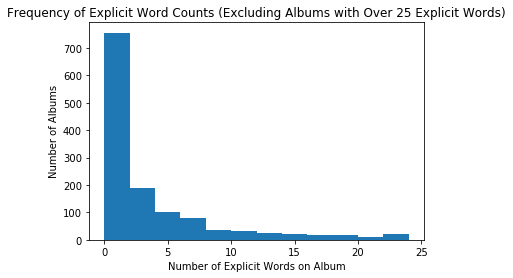

In [7]:
plt.hist(albums[albums["explicit_count"] <= 25]["explicit_count"], bins=np.arange(0, 26, 2))
plt.title("Frequency of Explicit Word Counts (Excluding Albums with Over 25 Explicit Words)")
plt.xlabel("Number of Explicit Words on Album")
plt.ylabel("Number of Albums")
plt.show()

Here, we observe that while the general distribution of explicit word counts is still skewed left, there still exists hundreds of albums that contain "occasional" explicit content, i.e. two to five explicit words. With this in mind, we move to explore the critical reception the albums in the dataset received.

##### Exploring Data on Critical Reception

As mentioned above, critical reception for each album is measured using `metascore`, an aggregate critical score in the 0-100 range computed by Metacritic.

In [8]:
# computing mean and standard deviations of metascores
print("The average metascore of the albums in the dataset is approximately", round(albums["metascore"].mean(), 2))
print("The standard deviation of album metascores is approximately", round(albums["metascore"].std(), 2))

The average metascore of the albums in the dataset is approximately 72.9
The standard deviation of album metascores is approximately 13.13


It is also worth noting the general ranges which Metacritic divides the full 0-100 scale into:
<br><br><img src="../metacritic_ranges.jpg">
<center>([Source](https://www.metacritic.com/about-metascores))</center>

We therefore see that on average, the albums in this dataset received "generally favorable reviews," based off the average metascore of 72.9. We can also compute and visualize the distribution of the metascores in the dataset based off the above method of categorization:

In [9]:
# computing number of albums in each category
num_universal_acclaim = len(albums[(albums["metascore"] >= 81) & (albums["metascore"] <= 100)])
num_generally_favorable = len(albums[(albums["metascore"] >= 61) & (albums["metascore"] <= 80)])
num_mixed_or_average = len(albums[(albums["metascore"] >= 40) & (albums["metascore"] <= 60)])
num_generally_unfavorable = len(albums[(albums["metascore"] >= 20) & (albums["metascore"] <= 39)])
num_overwhelming_dislike = len(albums[(albums["metascore"] >= 0) & (albums["metascore"] <= 19)])

|                               | Number of Albums in Category | Percentage of Albums in Category |
|:------------------------------|:----------------------------:|:--------------------------------:|
| Universal Acclaim             | 736                          | 49.07%                           |
| Generally Favorable Reviews   | 401                          | 26.73%                           |
| Mixed or Average Reviews      | 357                          | 23.80%                           |
| Generally Unfavorable Reviews | 6                            | 0.40%                            |
| Overwhelming Dislike          | 0                            | 0.00%                            |

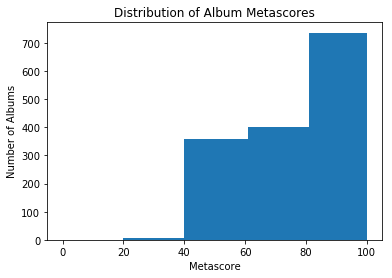

In [10]:
# creating histogram of metascores to visualize number of albums in each Metacritic category
plt.hist(albums["metascore"], bins=[0, 20, 40, 61, 81, 100])
plt.title("Distribution of Album Metascores")
plt.xlabel("Metascore")
plt.ylabel("Number of Albums")
plt.show()

Evidently, highly positive reviews are much more common than highly negative reviews, with zero albums in the dataset falling into the "Overwhelming Dislike" category and only six falling into the "Generally Unfavorable Reviews" category. This could reflect music critics' preference to not even waste time reviewing significantly flawed records--unless, for instance, these records are notably controversial or made by a prominent artist. Even then, however, not many critics might choose to review such records; and as mentioned above, all albums that fail to earn seven or more reviews from established music critics are not included in the dataset.

##### Linear Regression Analysis

Having performed some preliminary analysis on the `explicit_count`, `explicit_avg`, and `metascore` attributes of the dataset, we now will use linear regression to investigate the strength of a hypothetical linear relationship between the amount of explicit content on an album and its critical reception.

Before performing the actual linear regression analysis, however, we first create two scatterplots to approximate the impact `explicit_count` has on `metascore`, and similarly approximate the impact `explicit_avg` has on `metascore`:

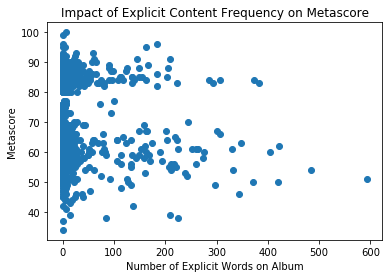

In [15]:
# creating scatterplot for explicit_count vs. metascore
plt.scatter(albums["explicit_count"], albums["metascore"])
plt.xlabel("Number of Explicit Words on Album")
plt.ylabel("Metascore")
plt.title("Impact of Explicit Content Frequency on Metascore")
plt.show()

It therefore seems that there does not exist a strong linear relationship between the number of explicit words on an album and its metascore.

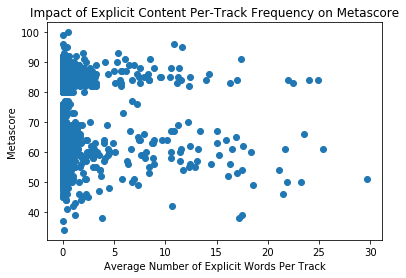

In [16]:
# creating scatterplot for explicit_avg vs. metascore
plt.scatter(albums["explicit_avg"], albums["metascore"])
plt.xlabel("Average Number of Explicit Words Per Track")
plt.ylabel("Metascore")
plt.title("Impact of Explicit Content Per-Track Frequency on Metascore")
plt.show()

Similarly, it does not seem that there exists a strong linear relationship between the average number of explicit words per track and the album's overall metascore.

We can confirm the above two observations by first fitting a linear regression that predicts `metascore` given `explicit_count`, then fitting a lienar regression that predicts `metascore` given `explicit_avg`:

In [14]:
# fitting linear model that predicts metascore given explicit_count
count_metascore_model = LinearRegression().fit(albums[["explicit_count"]], albums["metascore"])

# computing regression slope, intercept, and r^2 score
print("Regression slope (when predicting metascore given number of explicit words on album):", \
      float(count_metascore_model.coef_))
print("Regression intercept (when predicting metascore given number of explicit words on album):", \
      count_metascore_model.intercept_)
print("r^2 score (when predicting metascore given number of explicit words on album):", \
      count_metascore_model.score(albums[["explicit_count"]], albums["metascore"]))

Regression slope (when predicting metascore given number of explicit words on album): -0.0326851364251562
Regression intercept (when predicting metascore given number of explicit words on album): 73.5309409096
r^2 score (when predicting metascore given number of explicit words on album): 0.0195687135716


In [23]:
# fitting linear model that predicts metascore given explicit_avg
avg_metascore_model = LinearRegression().fit(albums[["explicit_avg"]], albums["metascore"])

# computing regression slope, intercept, and r^2 score
print("Regression slope (when predicting metascore given average # of explicit words per album track):", \
      float(avg_metascore_model.coef_))
print("Regression intercept (when predicting metascore given average # of explicit words per album track):", \
      avg_metascore_model.intercept_)
print("r^2 score (when predicting metascore given average # of explicit words per album track):", \
      avg_metascore_model.score(albums[["explicit_avg"]], albums["metascore"]))

Regression slope (when predicting metascore given average # of explicit words per album track): -0.45975471317382605
Regression intercept (when predicting metascore given average # of explicit words per album track): 73.4916580007
r^2 score (when predicting metascore given average # of explicit words per album track): 0.014536904011


As expected, neither of the two linear models above seem to indicate a notable linear relationship between the amount of explicit content on an album and its critical reception.

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

# Acknowledgements

All works cited are presented below:

Bannister, Mark. "The Billboard Hot 100: Exploring Six Decades of Number One 
     Singles." GitHub, Apr. 2017, [Repository Link](https://github.com/mspbannister/dand-p4-billboard/blob/master/Billboard_analysis__100417_.md#the-billboard-hot-100-exploring-six-decades-of-number-one-singles). Accessed 16 May 2020.
     
"Best Music and Albums for 2020." Metacritic, [Page Link](https://www.metacritic.com/browse/albums/score/metascore/year/filtered?view=condensed&sort=desc). Accessed 16 May 2020.

"Chart History: Prince." Billboard, [Page Link](www.billboard.com/music/prince/chart-history/HSI/song/333454). Accessed 16 May 2020.

"How We Create the Metascore Magic." Metacritic, [Page Link](https://www.metacritic.com/about-metascores). Accessed 19 May 2020.

Ross, Eleanor. "Parental Advisory: How Songs with Explicit Content Came to 
     Dominate the Charts." Newsweek, 13 Apr. 2017, [Page Link](https://www.newsweek.com/songs-explicit-lyrics-popular-increase-billboard-spotify-583551). Accessed 16 May 2020. 